# 3D Vision

# 感知方法
1. 从RGB图像推测
2. 通过Depth Camera推断
3. LiDar 点云，可视化三维世界

## 核心问题：我们如何看见世界
*   如果我们直接在物体前放一张胶片（或传感器），图像会是一片模糊。
*   **原因**：物体上的任何一点都会向四面八方发射光线，胶片上的任何一点都会同时接收到来自物体上所有点的光线，信息混杂在一起。

**解决方案一：小孔成像 (Pinhole Camera)**
*   在物体和胶片之间加一个**挡板 (Barrier)**，挡板上只开一个极小的**孔 (Aperture)**。
*   **效果**：这样，能够到达胶片上某一点的光线，就只能来自物体上的某一个特定点。光线被“筛选”了，从而形成清晰、但上下颠倒的图像。
*   这就是最基础、最理想的**针孔相机模型**，它是整个计算机视觉相机模型的理论基石。

**解决方案二：使用透镜 (Lens)**
*   **针孔模型的问题**：为了图像清晰，孔必须很小，但这会导致进光量太少，图像非常暗。如果把孔开大，图像又会变模糊。
*   **透镜的作用**：透镜可以在一个更大的“孔径”下，将来自物体同一点的多条光线**汇聚 (Focus)** 到胶片上的同一点。
*   **结果**：我们既获得了足够的亮度，又保证了图像的清晰度。现代相机就是这么工作的。
*   **关键概念**：
    *   **焦点 (Focal Point)**：平行光线经过透镜后汇聚的点。
    *   **焦距 (Focal Length, f)**：透镜中心到焦点的距离。焦距决定了相机的“视野”范围（长焦看得远但窄，广角看得近但宽）。

# 相机模型的数学化
我们的目标是建立一个数学公式，能够精确回答：**一个在三维空间中的点 P = (X, Y, Z)，会出现在二维照片的哪个像素位置 p = (u, v)？**

这个过程被拆解为两步：

## 步骤一：相机内部参数 (Intrinsics, K)

这部分只考虑相机自身的“出厂设置”，与它放在世界的哪个位置无关。

### 针孔摄像机成像公式

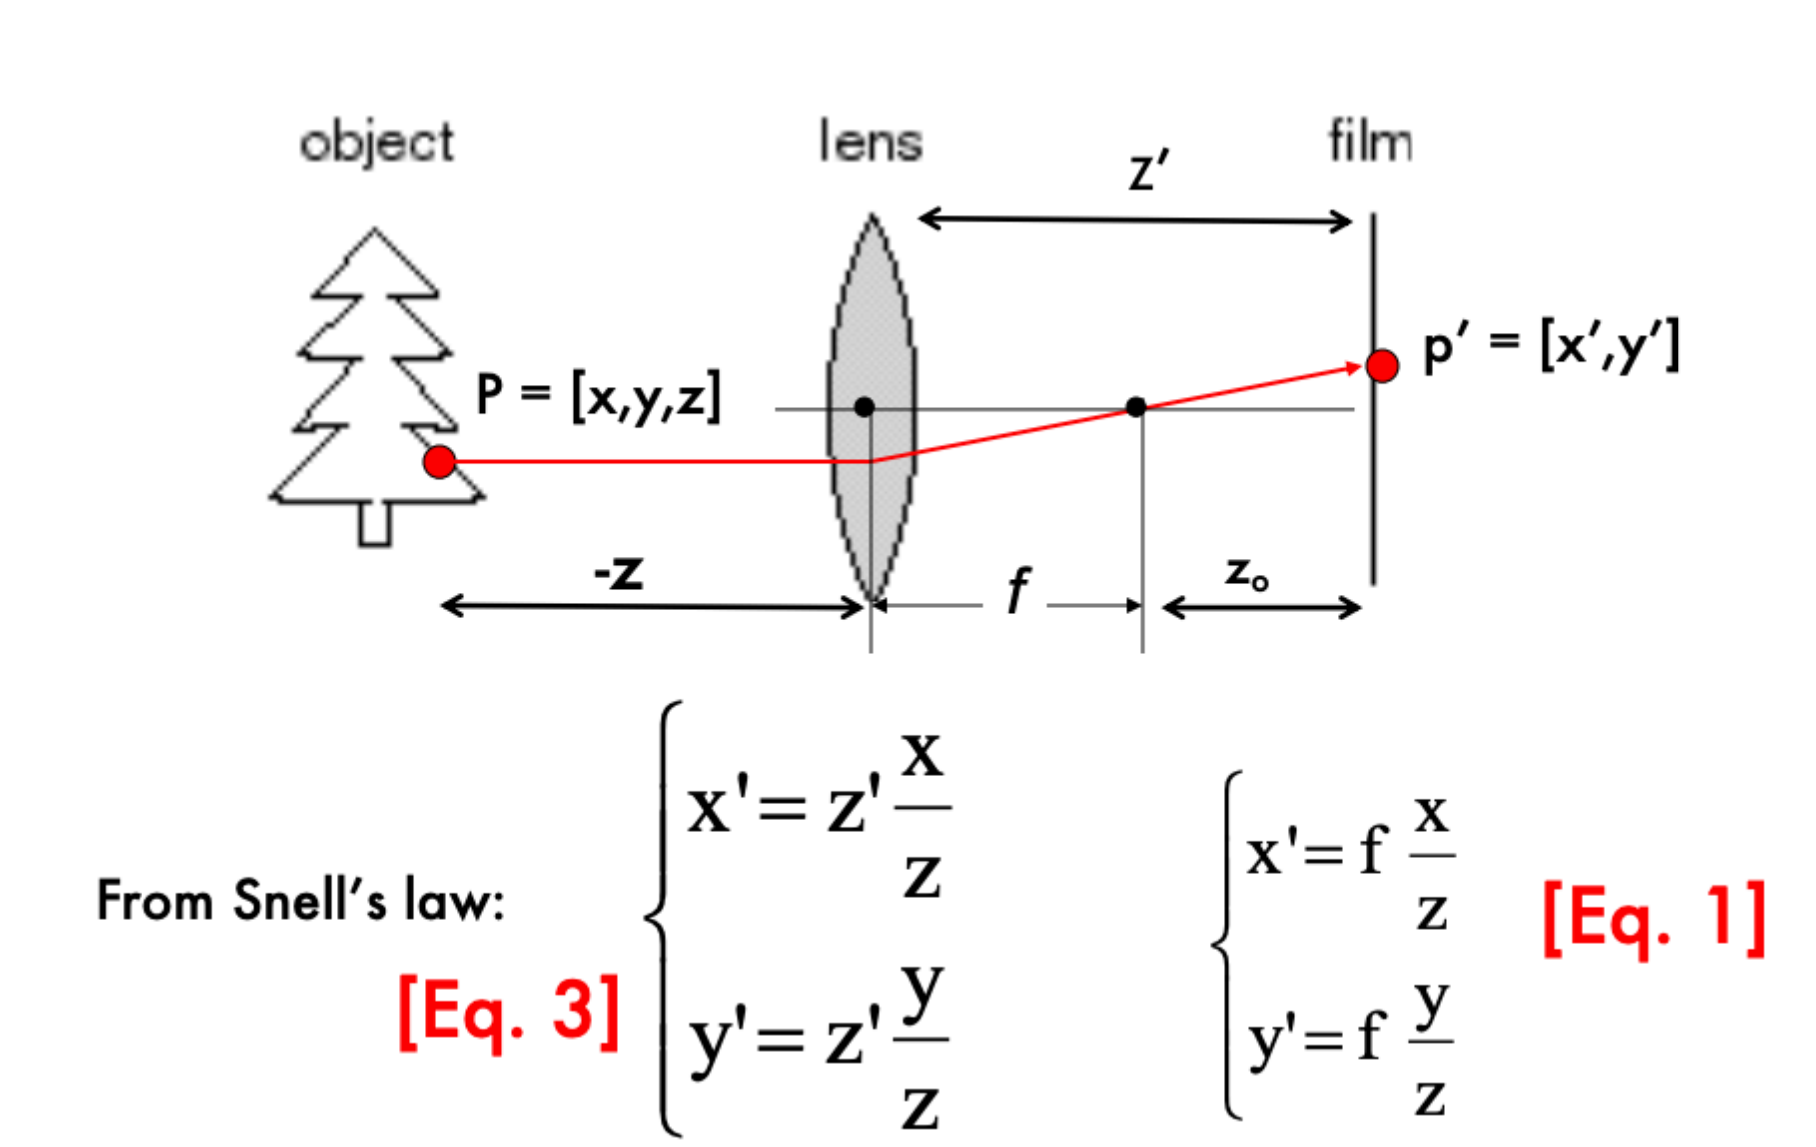

**Eq. 1 是如何得到的？**

Eq. 1 是在特定近似条件下，从 Eq. 3 推导出来的。下面是详细步骤：

**第一步：理解 Eq. 3 的来源**
根据相似三角形的性质，对应边的比例是相等的：
`x' / z' = x / z`
`y' / z' = y / z`

将 z' 乘到右边，就得到了 **Eq. 3**:
`x' = z' * (x/z)`
`y' = z' * (y/z)`

**第二步：从 Eq. 3 推导 Eq. 1**

要从 Eq. 3 得到 Eq. 1，我们只需要将 `z'` 替换为 `f`。那么，在什么情况下 `z'` 会约等于 `f` 呢？

这里需要用到**薄透镜成像公式**：
`1/z + 1/z' = 1/f`
（其中 z 是物距，z' 是像距，f 是焦距）

当**物体距离透镜非常远**时，即 z 的值非常大 (z → ∞)，那么 1/z 的值就趋近于 0。此时，成像公式就近似为：
`0 + 1/z' ≈ 1/f`
`z' ≈ f`

这意味着，对于远处的物体，它的像会清晰地呈现在透镜的焦平面上，像距约等于焦距。

因此，将 `z' ≈ f` 这个近似条件代入 Eq. 3，就得到了 **Eq. 1**:
`x' = f * (x/z)`
`y' = f * (y/z)`

### 从物理坐标到像素坐标:
*   `x'` 和 `y'` 是物理单位（比如毫米），但电脑里的图片是由**像素**组成的。我们需要一个转换。
*   `u = α * x' + cx`
*   `v = β * y' + cy`
*   **α, β**: 表示在x和y方向上，每毫米包含多少个像素。
*   **(cx, cy)**: 这是**主点 (Principal Point)**，即相机光轴与成像平面的交点。它在像素坐标系下的位置，通常接近图像中心。

### 矩阵表示
**关键工具：齐次坐标 (Homogeneous Coordinates)** 
*    `x' = f * (X/Z)` 中有一个除法，这不是线性变换，用矩阵运算不方便。
*   齐次坐标是一个“数学技巧”，通过增加一个维度（例如，(X, Y, Z) -> (X, Y, Z, 1)），可以将这个复杂的投影过程变成一个**单一的矩阵乘法**，极大地方便了计算机进行计算。
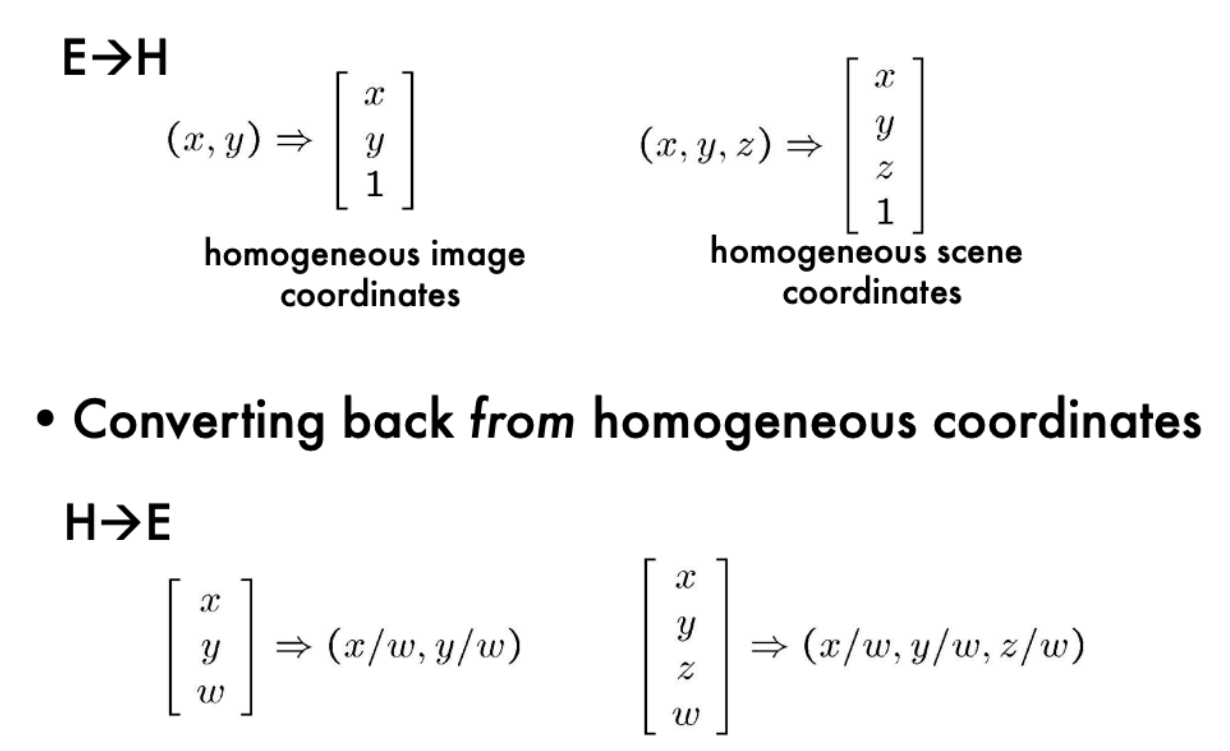

**整合为内参矩阵 K**:
*   为了方便计算，我们将 `α, β, cx, cy` 以及一个描述像素轴是否倾斜的**偏斜系数 (Skew, s)** 合并成一个 3x3 的矩阵，这就是**内参矩阵 K**。
*   `K` 包含了相机的焦距、主点位置、像素缩放比例等所有内部信息。它有 **5个自由度** (`α, β, cx, cy, s`)。
*   拿到一台相机，只要它的镜头和传感器不变，它的内参 `K` 就是固定的。这个过程叫**相机标定**。
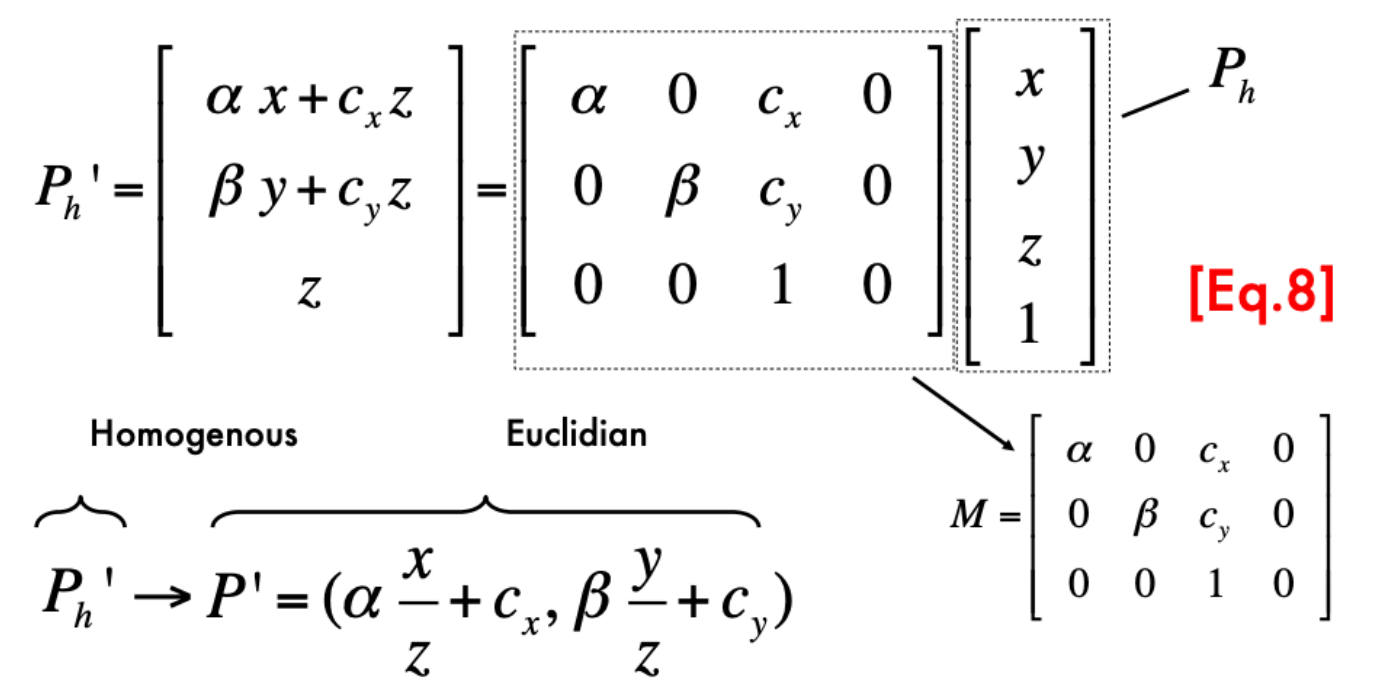
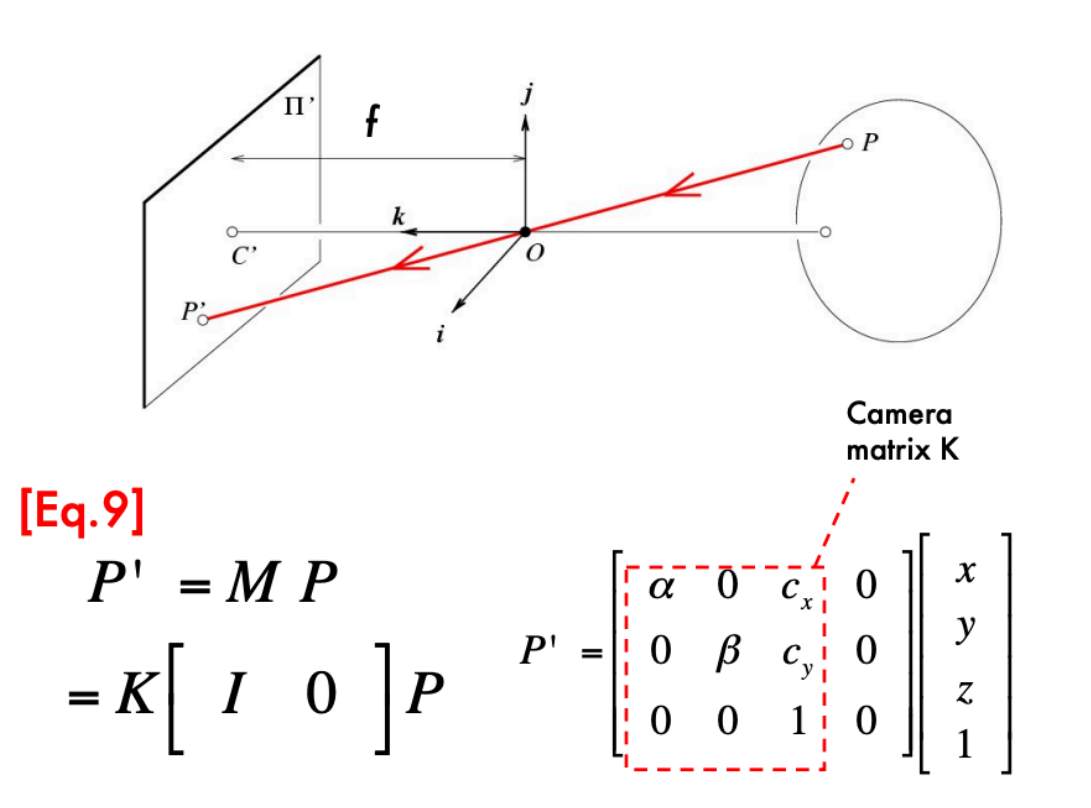

## 步骤二：相机外部参数 (Extrinsics, [R|T]) - 描述相机在世界中的位姿

这部分描述的是相机“摆放”的位置和“朝向”。

1.  **坐标系转换**:
    *   一个物体在**世界坐标系** (比如以房间一角为原点) 中有一个坐标 `P_world`。
    *   同一个物体在**相机坐标系** (以相机光心为原点) 中有另一个坐标 `P_camera`。
    *   我们需要一个方法来转换这两个坐标。

2.  **旋转 (Rotation, R) 和平移 (Translation, T)** :
    *   从世界坐标系到相机坐标系的转换，可以通过一个**旋转**和一个**平移**来完成。
    *   **R (旋转矩阵)**: 一个 3x3 的矩阵，描述了世界坐标系的坐标轴相对于相机坐标系的旋转角度（相机的朝向）。
    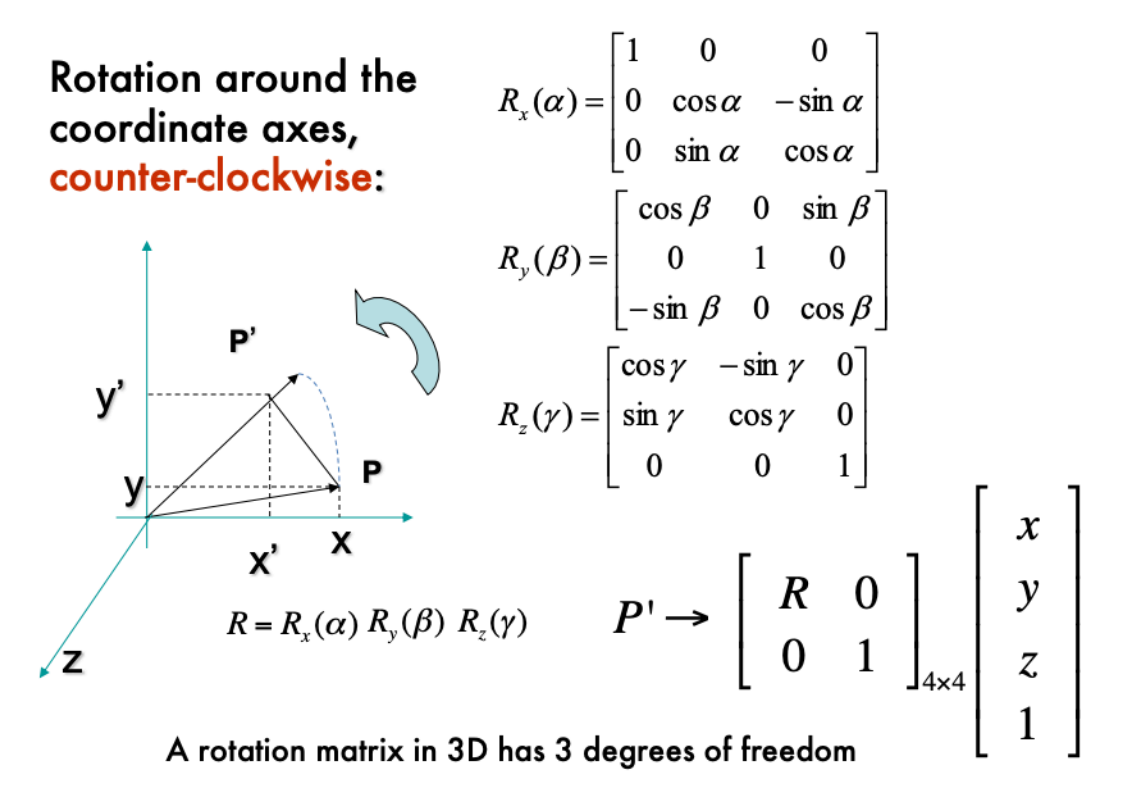
    *   **T (平移向量)**: 一个 3x1 的向量，描述了世界坐标系原点相对于相机坐标系原点的位置（相机的位置）。
    *   这两个参数合称为**外参矩阵 [R|T]**。它有 **6个自由度**（3个旋转+3个平移）。
    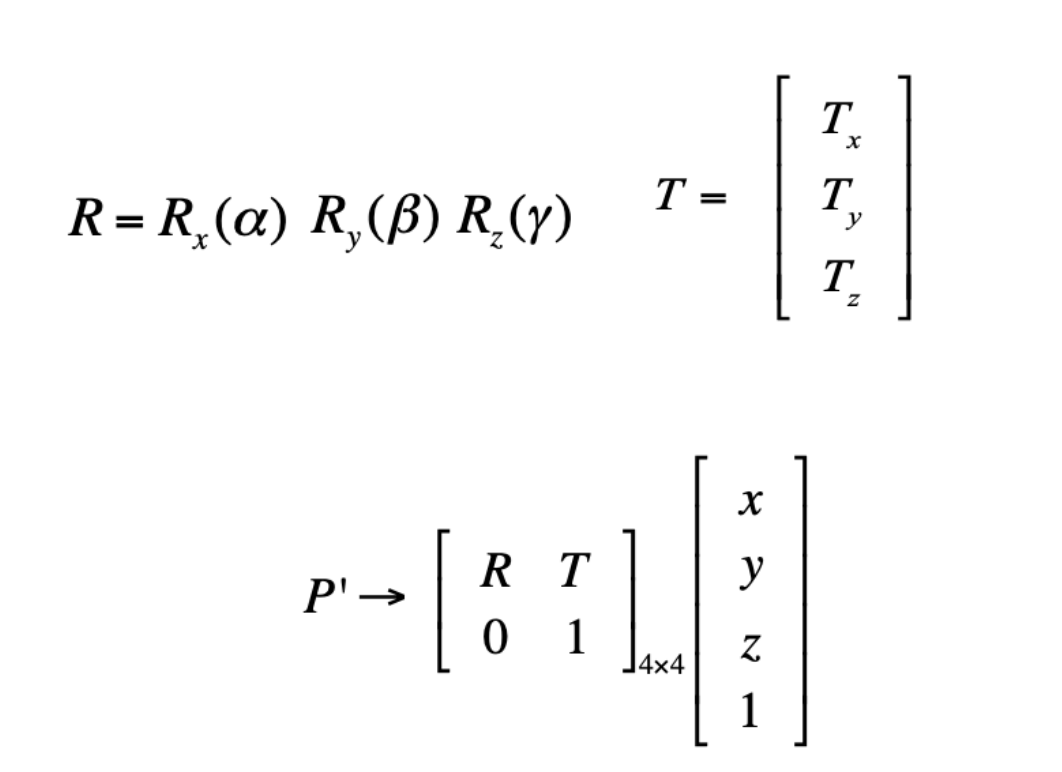

**最终公式：连接3D世界与2D图像**

现在，我们可以把所有步骤串起来了：

`p = K * [R|T] * P_world`

*   **P_world**: 世界中的一个三维点。
*   **[R|T]**: 通过外参，将 `P_world` 转换到相机坐标系下。
*   **K**: 通过内参，将相机坐标系下的三维点投影到成像平面，并转换为像素坐标 `p`。

## 第三部分：模型的简化与变种

完整的透视投影模型虽然精确，但有时计算复杂。在特定条件下，我们可以用更简单的模型来近似。

**1. 弱透视投影 (Weak Perspective)**
*   **条件**：当物体离相机非常远，并且物体本身的深度范围远小于它到相机的距离时（比如航拍城市）。
*   **近似**：我们可以认为物体上所有点的深度 Z 都约等于一个平均深度 Z₀。
*   **效果**：`x' = (f/Z₀) * X`。这不再是透视投影，而是一个**均匀缩放**，再加上一个平移。数学上简单很多。
*   **特点**：平行线投影后依然是平行线。
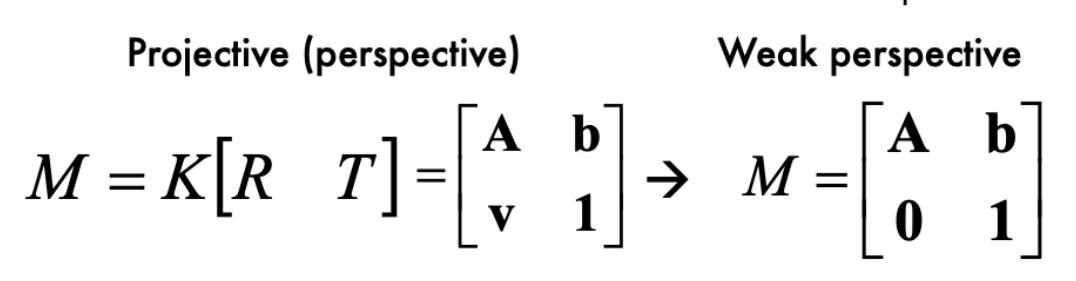
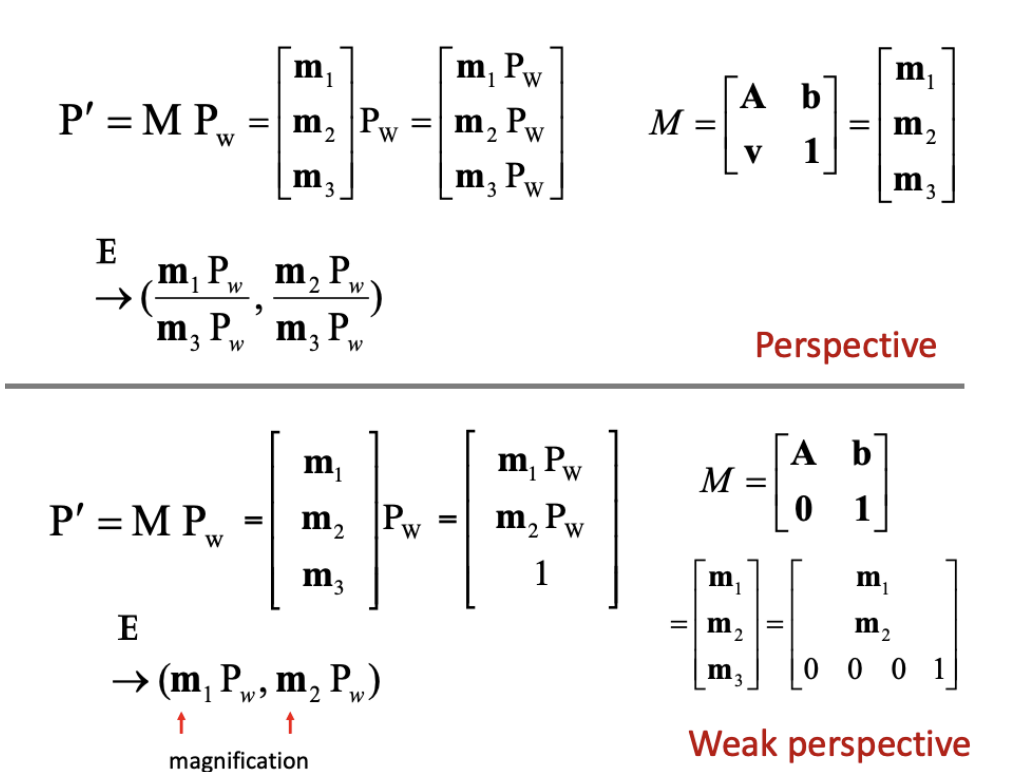

**2. 正交/仿射投影 (Orthographic/Affine Projection)**
*   **条件**：可以看作是弱透视的极端情况，相当于相机在无限远处。
*   **近似**：完全忽略深度Z，直接将X, Y坐标“拍扁”到图像上。`x' = X, y' = Y`。
*   **特点**：物体的大小不会随距离而改变。常用于工程制图（如CAD）和一些物体识别任务。


# 相机标定 (Camera Calibration)
## 所需物品和数据
1.  **一台待标定的相机**。
2.  **一个标定物 (Calibration Rig)**：最常用的是**棋盘格 (Checkerboard)**。它的关键优势在于，我们**精确地知道**它上面每一个角点在它自己的三维坐标系下的坐标（比如，左上角是(0,0,0)，旁边是(20mm, 0, 0)等）。
3.  **一组点对 (Correspondences)**：这是整个标定的**数据基础**。
    *   我们拍摄标定物的照片。
    *   在照片中，我们可以**精确地找到**棋盘格角点对应的**二维像素坐标 (p)**。
    *   这样，我们就得到了一系列“**已知的3D世界点 `P`**”和它们对应的“**已知的2D图像点 `p`**”的配对。

## 核心算法：如何从“点对”求解“相机参数”？

这是课程的数学核心，整个过程可以分为三个关键步骤：

### 第一步：建立方程，求解混合矩阵 M

1.  **核心公式**：我们从相机的投影公式出发 `p = M * P`。
    *   `p` 是已知的2D像素点坐标。
    *   `P` 是已知的3D世界点坐标。
    *   `M = K[R|T]` 是一个3x4的矩阵，它**混合了**所有内参和外参，是我们要解的**“中间变量”**。

2.  **构建线性方程组**：
    *   上面的公式 `p = M * P` 包含除法，不方便直接求解。通过数学变换（利用齐次坐标），我们可以将它转换成一个没有除法的**线性方程组** `A * m = 0`。
    *   其中，向量 `m` 是由矩阵 `M` 的12个元素拉直而成的。矩阵 `A` 则是由我们已知的点对 `p` 和 `P` 的坐标构成的。
    *   每一个点对 `(p, P)` 可以提供**两个**独立的线性方程。

3.  **求解 `M`**：
    *   矩阵 `M` 有11个未知数（自由度）。因此，我们至少需要 11/2 ≈ 5.5 个点对，即**至少6个三维空间中的非共面点**，才能唯一地解出 `M`。
    *   在实践中，我们会用远多于6个点来提高解的**鲁棒性**和**精度**。
    *   求解 `A * m = 0` 这个问题，有一个非常强大的数学工具——**奇异值分解 (SVD)**。通过SVD，我们可以高效地求出向量 `m`，然后将其重新组合成3x4的矩阵 `M`。

### 第二步：拆解矩阵 M，分离内外参数
*   `M = K[R|T]`
*   通过一系列精巧的矩阵运算（比如QR分解），我们可以从3x4的矩阵 `M` 中，把 3x3 的**内参矩阵 `K`** 和 3x4 的**外参矩阵 `[R|T]`** 分离出来。

好的，我们来通俗易懂地讲解一下这张PPT。

这张PPT讲的是**相机标定（Camera Calibration）**过程中的一个关键步骤。

---

#### 为什么要“归一化” (Normalize)

在求解相机矩阵 M 的过程中，我们通常会根据很多组已知的“3D世界点”和它们对应的“2D图像点”来列立一个线性方程组，形式通常是 `Ax = 0`。

解这种方程组会遇到一个问题：**解不唯一**。

*   如果 `M` 是这个方程组的一个解，那么任何一个常数 `c` 乘以 `M`（也就是 `cM`）也同样是解。
*   这是因为在齐次坐标系下，一个点 `(x, y, w)` 和 `(cx, cy, cw)` 表示的是同一个点。所以 `M` 和 `cM` 对于成像结果是等价的。

为了解决这个“解不唯一”的问题，我们**让解的“长度”或“范数”等于1**，这个被施加了 `||M̂||_F = 1` (Frobenius范数为1) 约束的解，就是我们所说的**归一化(normalized)的相机矩阵 M̂**。

#### 如何“去归一化” (Unnormalize)？

需要找到那个正确的**缩放因子 ρ (rho)**。

**M = ρ * M̂**
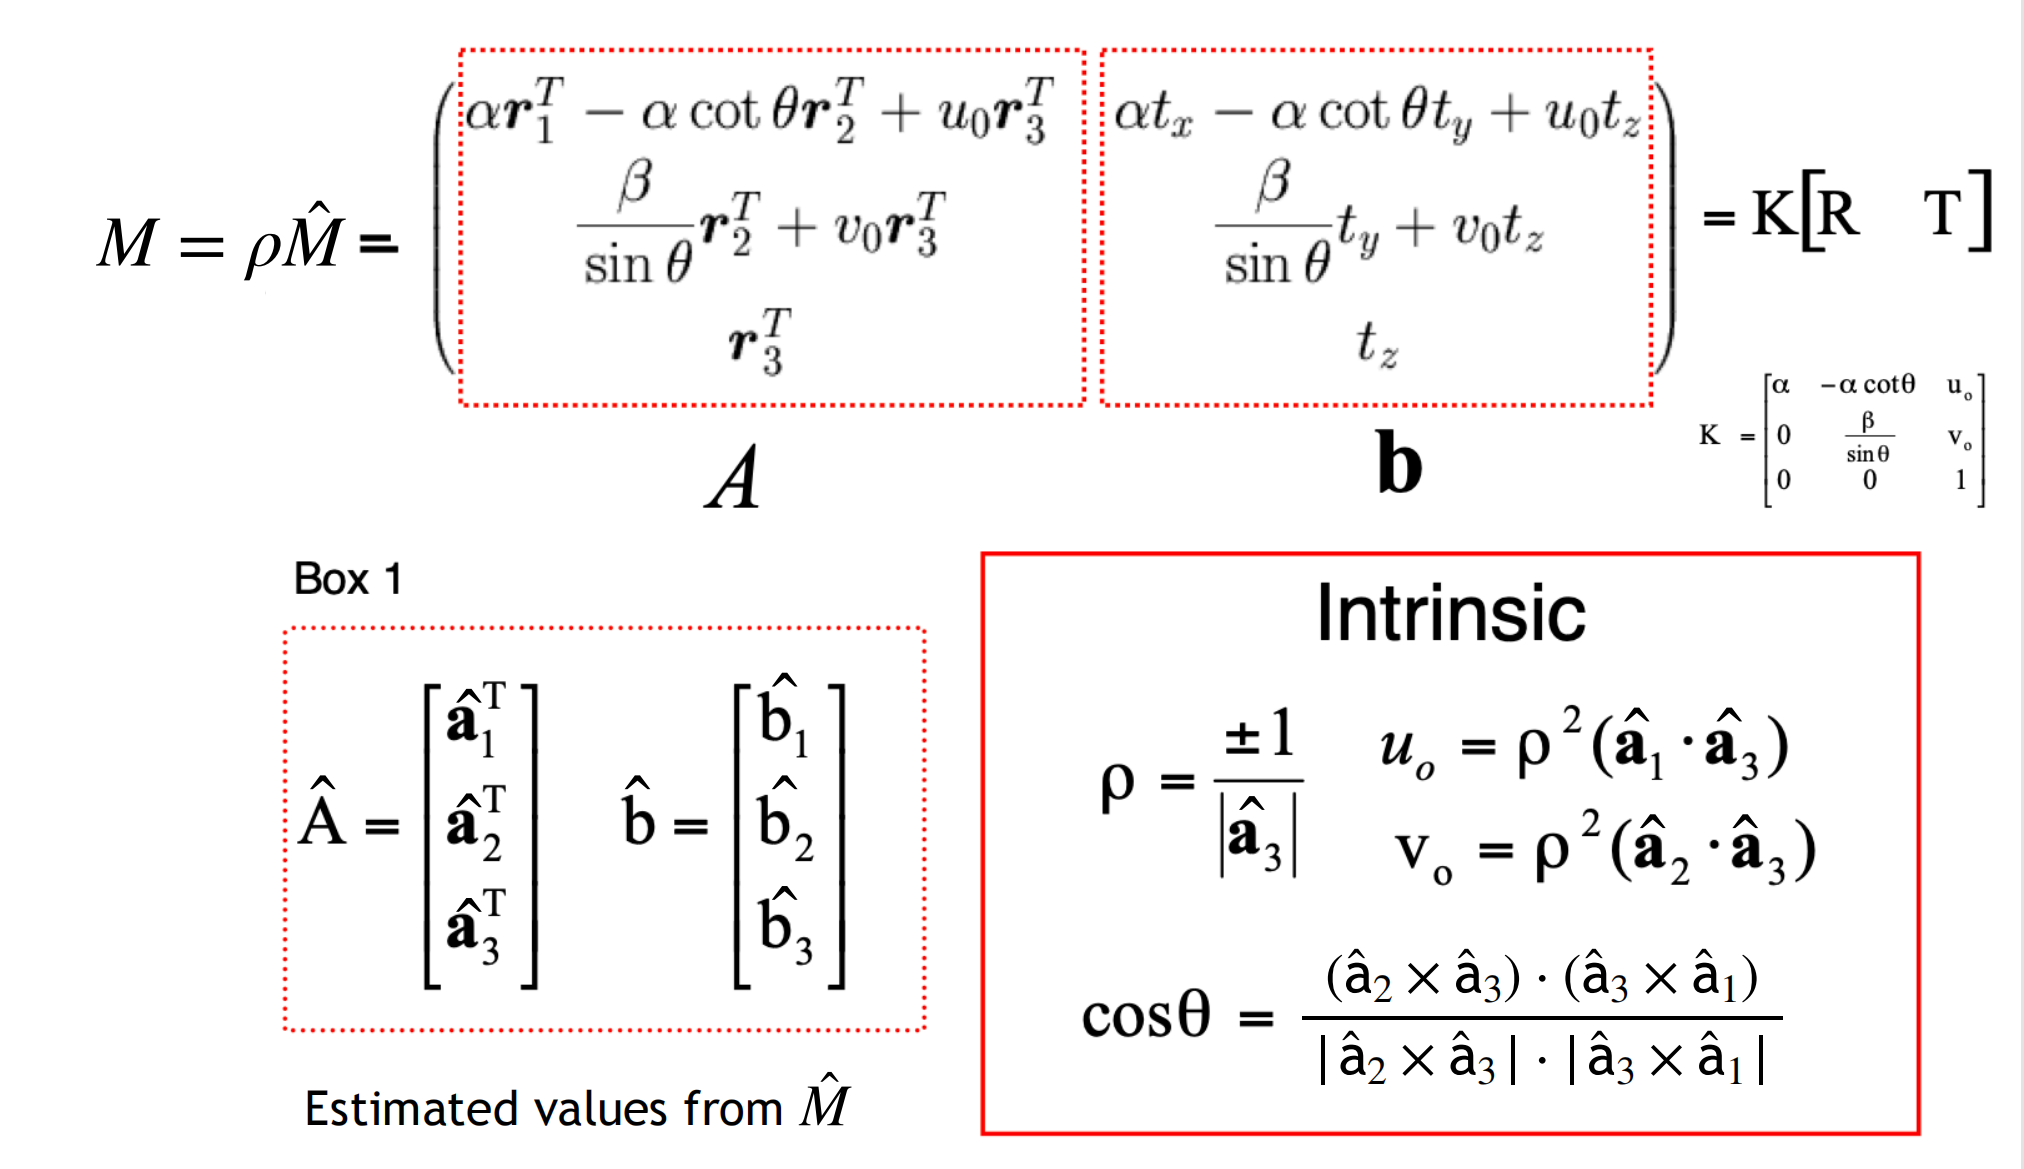

#### 标定点为什么不能都在同一个平面上
会导致相机参数解的混淆和不唯一，当所有点都在一个平面上时，我们失去了在深度方向上的约束信息。相机不知道这个平面到底是近一点、小一点，还是远一点、大一点。

### 第三步：考虑真实世界，进行优化和校正

前两步是基于理想的针孔模型的线性解法。但在真实世界中，存在两个问题：

1.  **镜头畸变 (Lens Distortion)**：真实的镜头不是完美的，它会使图像产生形变，最常见的是**径向畸变**（桶形或枕形畸变）。直线在图像边缘会变弯。
2.  **测量噪声 (Noise)**：我们检测到的角点像素坐标不可能100%精确。

### 误差分析方法

#### A. 宏观分析：评估标定总体的健康状况

首先，忽略颜色和个别奇怪的点，只看**点的总体分布趋势**。

1.  **看中心密集区**：图中绝大多数点（红、蓝、黑、绿等）都紧密地聚集在原点(0,0)附近。这个密集区域的范围大致在x、y方向的±1个像素以内。
2.  **得出初步结论**：
    *   **这是一个不错的标定结果**。因为大部分误差都小于1个像素，这在多数应用中是可接受的。
    *   **核心模型大概率是正确的**。这说明我们所用的相机数学模型（针孔模型+畸变模型）本身是适用于这台相机的，并且我们求解出的**内参矩阵K**（它对所有照片都生效）是比较准确的。

#### B. 微观分析：识别不同模式的误差并诊断病因

现在，我们开始关注那些“不和谐”的点，并利用颜色信息来诊断问题的根源。这正是你老师所做的事情。

**模式一：中心密集、表现良好的点集（例如红色、蓝色点）**

*   **观察**：这些点紧密围绕(0,0)随机分布，没有明显的方向性偏移。
*   **诊断**：这是**理想的随机噪声**。它来自于像素的量化误差、角点检测算法的微小不精确等。这种误差是不可避免的，也是健康的。
*   **结论**：这些颜色所对应的照片质量很高，计算出的**外参[R|T]**也非常精确。它们共同验证了我们**内参K**的正确性。

**模式二：零散的、极端远离中心的离群点（例如x≈-4的几个黑色点）**

*   **观察**：只有极少数的点，孤零零地分布在离中心非常远的地方，与大部队完全脱节。
*   **诊断**：这几乎不可能是相机模型的问题。如果模型有问题，会影响一批点，而不是单个点。
*   **最可能的原因**：**角点检测算法出错了**。可能在那个特定的角点位置，由于光线反射、棋盘格边缘模糊等原因，算法给出了一个完全错误的像素坐标。
*   **结论**：这是**可以（也应该）被剔除的误差点**。它们是统计上的“outlier”，把它们留在数据集中会“带偏”我们对整体误差的评估，甚至会影响非线性优化的结果。

**模式三：整体发生系统性偏移的点集（例如紫粉色点）**

*   **观察**：这一整簇紫粉色的点，它们内部之间靠得很近，形成了一个小团体。但这个团体的**中心**明显偏离了原点(0,0)，整体向右上方偏移。
*   **诊断**：这不是随机噪声，而是**系统性偏差 (Systematic Bias)**。
*   **推理过程**：
    1.  我们的内参K是正确的，因为模式一中的红蓝点已经验证了它。内参K对所有照片都一样。
    2.  问题一定出在**只对这张紫粉色照片生效的参数**上。就是这张照片对应的**外参[R|T]**。
*   **最可能的原因**：
    *   **这张照片本身质量不佳**：比如拍摄时手抖导致了**运动模糊**，或者棋盘格的一部分**脱离了焦平面**导致模糊。模糊会使所有角点的检测都产生一个系统性的、同方向的微小偏移。
    *   **拍摄角度过于极端**：例如，相机几乎与棋盘格平面平行。此时，透视畸变极其严重，理想的针孔模型可能会出现较大偏差，导致计算出的外参不准。
*   **结论**：这张照片（紫粉色点所代表的）是一个“坏样本”。它所计算出的外参[R|T]是**不可靠的**。在追求高精度的标定中，这张照片应该被**舍弃**。

### 第三步：优化

1.  **数据清洗 (Data Cleansing)**：编写脚本或手动移除那些极端的离群点（模式二）。
2.  **样本筛选 (Sample Filtering)**：找出对应系统性偏差（模式三，紫粉色）的原始照片。检查它是否有模糊、过曝、角度极端等问题。如果确认是坏样本，就将其从标定图片集中移除。
3.  **重新标定 (Re-calibration)**：使用清洗和筛选后的“高质量”数据集，重新运行完整的标定算法（包括非线性优化）。
4.  **最终验证 (Final Verification)**：再次查看新生成的重投影误差图。理想情况下，所有的点都应该像模式一那样，紧密、随机地团结在原点(0,0)周围，总体的平均误差也会显著下降。

从数据反推问题的思维框架：

1.  **理解指标**：首先要清晰地知道图上每个点、每条轴、每个颜色的物理意义。
2.  **先整体，后局部**：先看数据的总体分布，对结果有一个宏观判断。再深入分析局部异常，寻找线索。
3.  **分离共性与个性**：思考哪些因素是影响**所有数据**的（共性，如内参K），哪些是只影响**部分数据**的（个性，如某张照片的外参[R|T]）。
4.  **区分随机与系统误差**：随机误差（如高斯噪声）通常无法消除，但可以接受。系统误差（如整体偏移）则明确指向了模型或数据源的某个特定环节出了问题，必须被定位和修正。
5.  **形成假设，验证，迭代**：根据数据模式提出假设（“我认为是第5张照片模糊了”），然后去验证这个假设（查看原始照片），最后采取行动（删除照片并重跑实验），形成一个发现问题 -> 定位问题 -> 解决问题的闭环。
